# Exploratory Data Analyses
Here I explore the text data we cleaned in Harvard_data. 

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [111]:
df = pd.read_csv('data/clean_df.csv', index_col = 0)

In [115]:
# re-list description column
df.description = df.description.apply(lambda x: str(x).split(','))

In [116]:
# removing columns where more than 50% of data are missing info
df = df[df.columns[df.isnull().sum()<(len(df)*0.5)]]

In [117]:
#pd.options.display.max_columns = None

In [118]:
# removing some other information we don't need
df = df[['id', 'objectnumber', 'title', 'description', 'people', 'colorcount',  'colors', 
    'datebegin', 'dateend','century','medium', 'culture', 'department', 'division']]

# Cultural differences in description
First let's see if words used to describe paintings for different cultures are unique. 

In [55]:
#df.culture.value_counts('culture')

For the sake of keeping enough data within each bin, I'll combine some of these culture to larger groups.  


In [119]:
cnd = [
    df.culture.isin(['Korean', 'Japanese', 'Chinese', 'Tibetan', 'Thai']),
    (df.culture.str.contains("Italian") | df.culture.isin(['Minoan', 'German', 'British', 'Roman', 'French', 
                                                           'Spanish', 'Flemish?', 'European', 
                                                          'Dutch', 'Greek', 'Irish', 'English'])),
    df.culture.isin(['American', 'Canadian']), 
    df.culture.isin(['Indian', 'Mughal'])]
vals = ['East_Asian', 'European', 'North_American', 'Indian']
df['macro_culture'] = np.select(cnd, vals, default='others')

In [120]:
df.macro_culture.value_counts('macro_culture')

East_Asian        0.341113
Indian            0.314183
North_American    0.195691
European          0.086176
others            0.062837
Name: macro_culture, dtype: float64

## Word Frequencies
I'll create a few functions to count the word frequencies and to plot out a word cloud.

In [129]:
def count_words(list_):
    """
    input: list of preprocessed strings (refer to data preprocessing)
    output: dictionary of word counts for each unique words
    """
    uniques = set(list_)
    counts = dict.fromkeys(uniques, 0)
    for word in list_:
        counts[word] += 1
    return {k: v for k, v in sorted(counts.items(), 
                                    reverse = True, key=lambda item: item[1])}
    

In [122]:
from wordcloud import WordCloud

In [137]:
def plot_words(dict_, title, fname):
    """
    input: a dictionary of word counts, title of the graph (str), and a filename (str)
    output: barplot for first 30 words and wordcloud, and save out files
    """
    X = list(dict_.keys())[0:30]
    Y = list(dict_.values())[0:30]
    
    plt.figure(figsize=(8, 6))
    
    ax = sns.barplot(x=X, y=Y, palette="husl")
    ax.set(ylabel= 'counts', xlabel= '', title = title)
    ax.set_xticklabels(X, rotation=90) # rotate labels 90 degree
    
    plt.tight_layout() # make sure labels are not cropped in saved files
    plt.show()
    
    ax.figure.savefig(f"PNG/{fname}.png")
    
    wc = WordCloud(background_color="white", width=600, height=400, max_words=50)
    wc.generate_from_frequencies(dict_)

    plt.imshow(wc, interpolation="bilinear")
    
    wc.to_file(f"PNG/{fname}_wc.png")
    
    plt.axis("off")
    plt.show()


In [139]:
East_Asian = sum(df[df.macro_culture == 'East_Asian']['description'], [])
European = sum(df[df.macro_culture == 'European']['description'], [])
North_American = sum(df[df.macro_culture == 'North_American']['description'], [])
Indian = sum(df[df.macro_culture == 'Indian']['description'], [])
others = sum(df[df.macro_culture == 'others']['description'], [])

In [234]:
cultures = {'East_Asian': East_Asian, 'European': European, 'North_American': North_American, 'Indian': Indian, 
            'others': others}

n_arts = df.macro_culture.value_counts()

for k,v in cultures.items():
    print(f"{k} has {len(v)} words, \n and an average {round(len(v)/n_arts[k])} words per art")


East_Asian has 15548 words, 
 and an average 82.0 words per art
European has 608 words, 
 and an average 13.0 words per art
North_American has 1471 words, 
 and an average 13.0 words per art
Indian has 10967 words, 
 and an average 63.0 words per art
others has 1005 words, 
 and an average 29.0 words per art


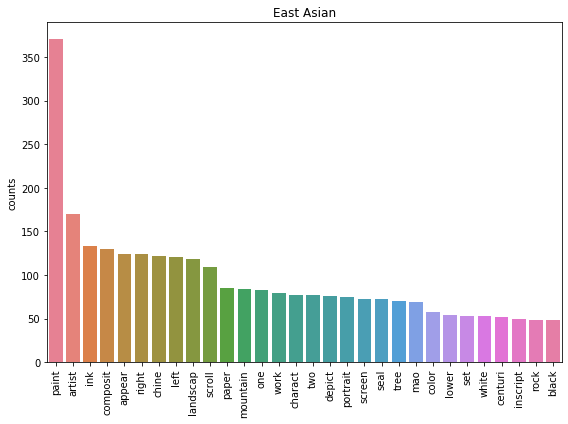

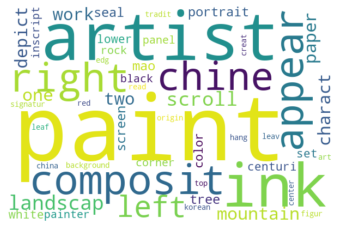

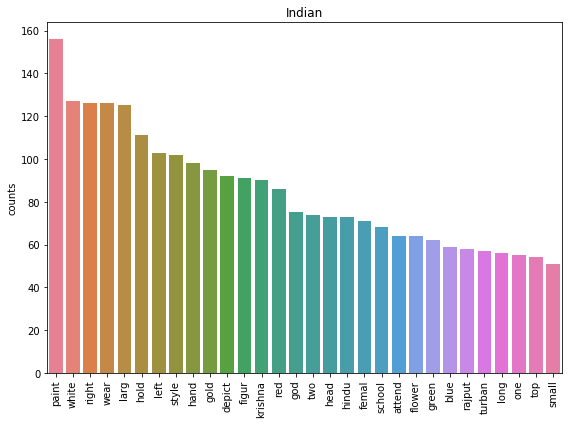

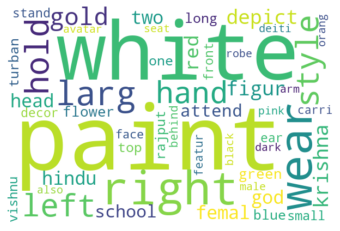

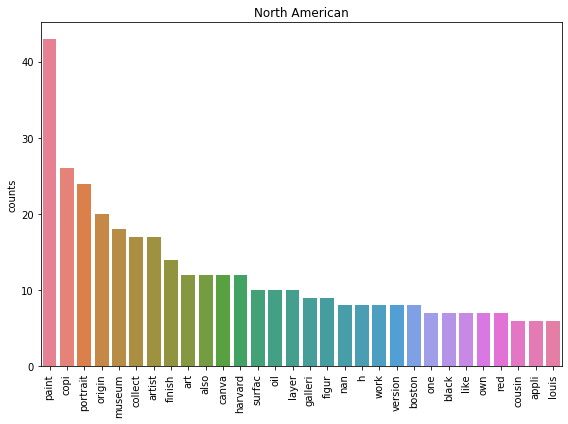

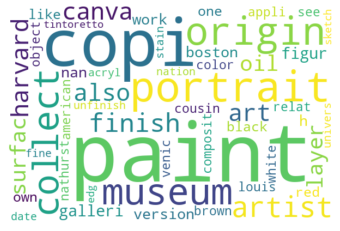

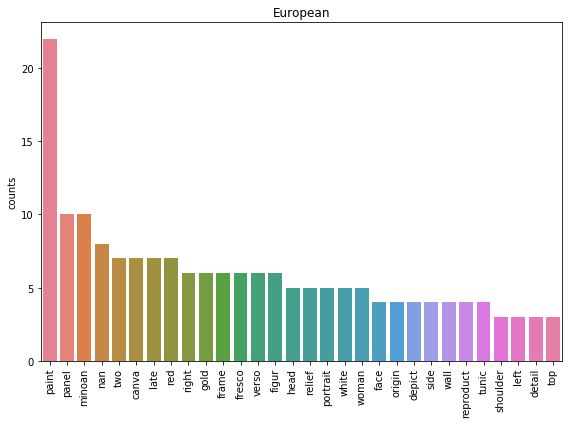

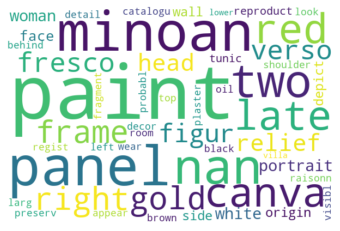

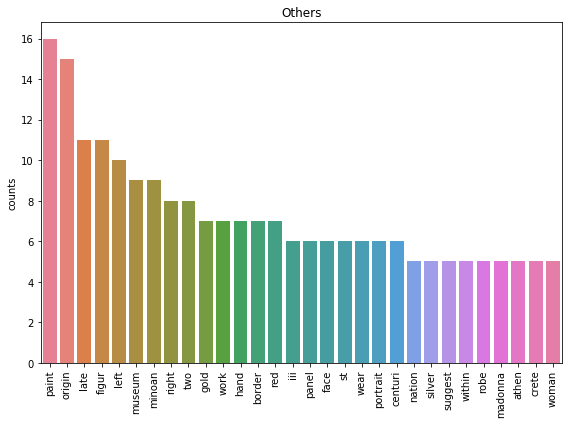

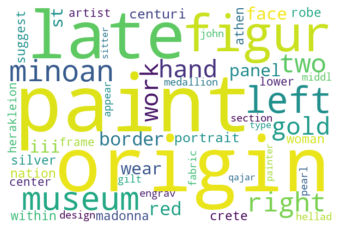

In [141]:
plot_words(count_words(East_Asian), "East Asian", "east_asian")
plot_words(count_words(Indian), "Indian", "indian")
plot_words(count_words(North_American), "North American", "north_american")
plot_words(count_words(European), "European", "european")
plot_words(count_words(others), "Others", "others")

While it's a bit difficult to infer trends from north american, european and others set, because they have much smaller amount of descriptive data. (Less art with descriptions and much less words per arts.) compared to Indian and East Asian collections. 
From Indian and East Asian collections, we can see that frequent words are much more colorful for Indian artworks, while most color descriptors used for East-Asian works being Black, White and color itself. 
For Indian artworks, Krishna river seems to be a common topic depicted in the collection.  
Additionally, specific cultural references used include hindu, rajput, and turban. 
On the other hand, there aren't much specific cultural references in East Asian descriptions, other than 'Chinese' and 'Mao'. It's evident that there are many non-specific landscape references in East-Asian words, this may imply higher abstraction in east-asian artworks. 

# Periodical difference in description
Now we'll see if there's any difference in frequency of words used throughout different time periods.

In [185]:
# dealing with '0' values in date end
cnd = [
    ((df.dateend == 0) & (df.century.isin(["19th-20th century", "20th century"]))),
    ((df.dateend == 0) & (df.century.isin(["19th century", "18th-19th century"]))),
    ((df.dateend == 0) & (df.century.isin(["18th century"]))),
    ((df.dateend == 0) & (df.century.isin(["17th-16th century BCE", "17th century", "16th-17th century"]))),
    ((df.dateend == 0) & (df.century.isin(["16th century"]))),
    ((df.dateend == 0) & (df.century.isin(["15th century"]))), 
    ((df.dateend == 0) & (df.century.isin(["2nd century CE"])))]
vals = [1900, 1800, 1700, 1600, 1500, 1500, 200]
df['date'] = np.select(cnd, vals, default=df.dateend)

In [238]:
# re-binning for each time period
bins = [-2000, 1500, 1600, 1700, 1800, 1900, 2000, 2020]
df['date_bins'] = pd.cut(df['date'], bins, labels = ["Pre_15th", "16th", "17th", "18th", "19th", "20th", "21st"])

In [239]:
_21st = sum(df[df.date_bins == "21st"]['description'], [])
_20th = sum(df[df.date_bins == "20th"]['description'], [])
_19th = sum(df[df.date_bins == "19th"]['description'], [])
_18th = sum(df[df.date_bins == "18th"]['description'], [])
_17th = sum(df[df.date_bins == "17th"]['description'], [])
_16th = sum(df[df.date_bins == "16th"]['description'], [])
_15th = sum(df[df.date_bins == "Pre_15th"]['description'], [])


In [240]:
periods = {'21st': _21st, '20th': _20th, '19th': _19th, '18th': _18th, 
            '17th': _17th, '16th': _16th, 'Pre_15th': _15th}

n_art2 = df.date_bins.value_counts()

for k,v in periods.items():
    print(f"{k} has {len(v)} words, \n and an average {round(len(v)/n_art2[k])} words per art")


21st has 3216 words, 
 and an average 189.0 words per art
20th has 6511 words, 
 and an average 56.0 words per art
19th has 9265 words, 
 and an average 50.0 words per art
18th has 4698 words, 
 and an average 57.0 words per art
17th has 2818 words, 
 and an average 59.0 words per art
16th has 1531 words, 
 and an average 22.0 words per art
Pre_15th has 1560 words, 
 and an average 42.0 words per art


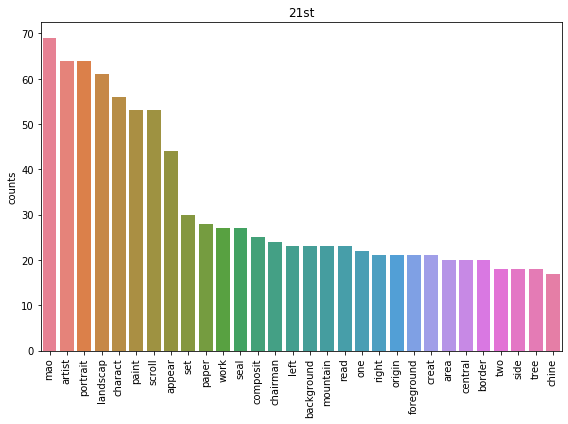

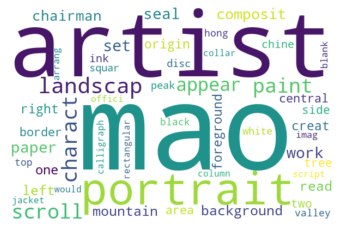

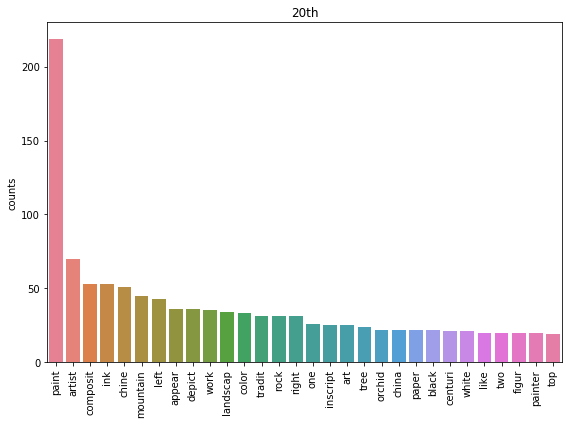

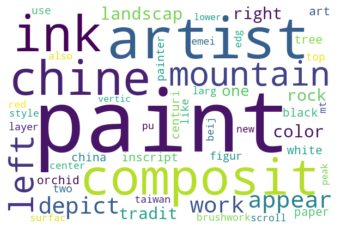

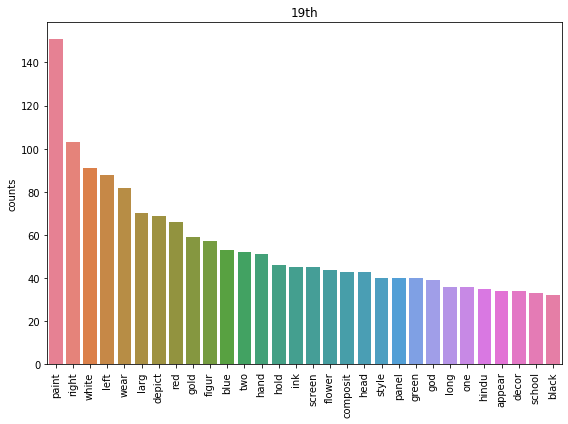

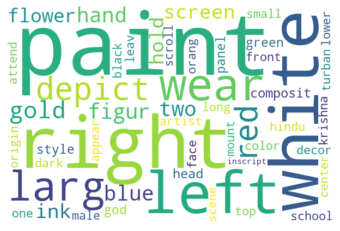

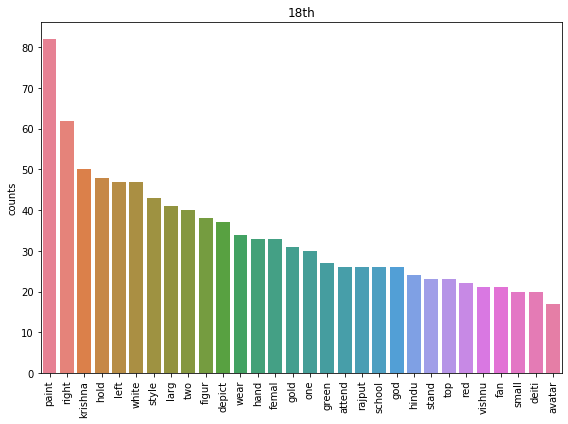

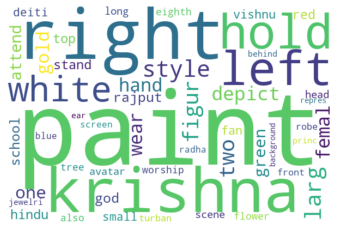

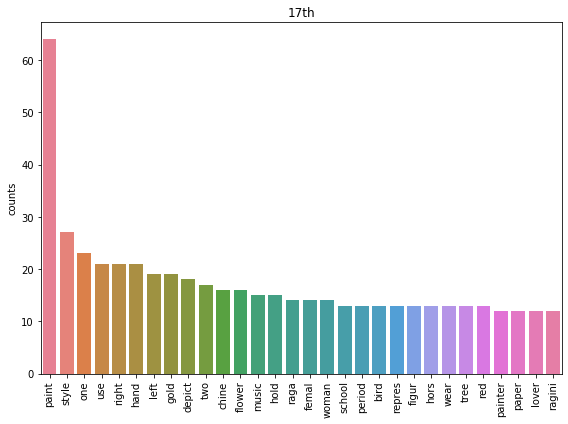

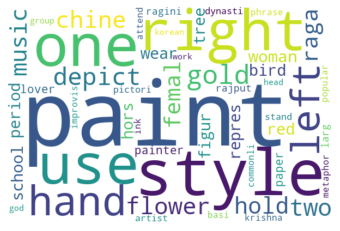

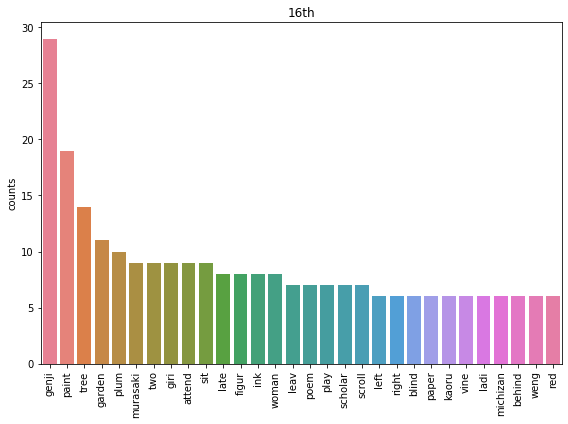

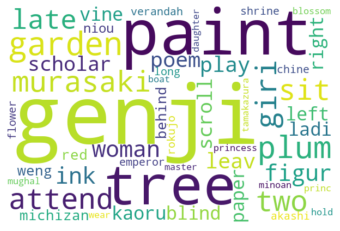

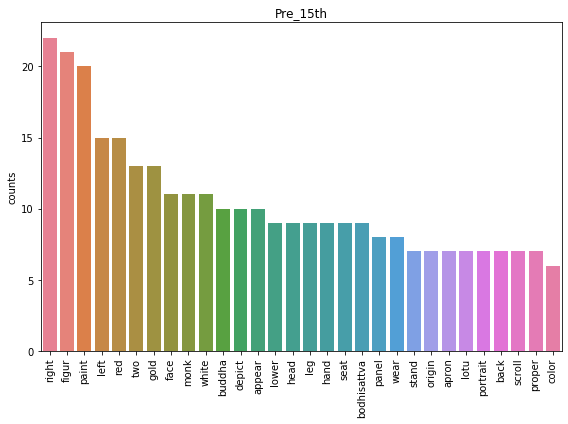

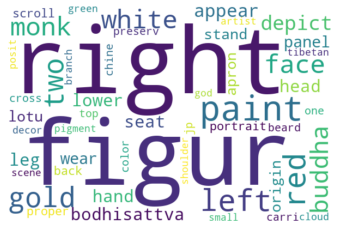

In [241]:
for k, v in periods.items():
    plot_words(count_words(v), k, k)


In [200]:
abstract_df = clean_df[(clean_df.description.apply(lambda x: 'abstract' in x))]

NameError: name 'clean_df' is not defined

In [ ]:
words = sum(abstract_df.description, [])
unique = set(words)
counts = dict.fromkeys(unique, 0)
for w in words: 
    counts[w] += 1

In [ ]:
counts = {k: v for k, v in sorted(counts.items(), reverse = True, key=lambda item: item[1])}